# Assignment 1 - Loss functions and gradient descent

Paul E. Anderson

In [8]:
%load_ext autoreload
%autoreload 2


import numpy as np

import sys
sys.path.insert(0,'..') # Change this based on your system

import py487

## Notes:
In this assignment and when calculating the log, I add a small value 1e-10 to make sure that we are always > 0.

### Generate a dataset

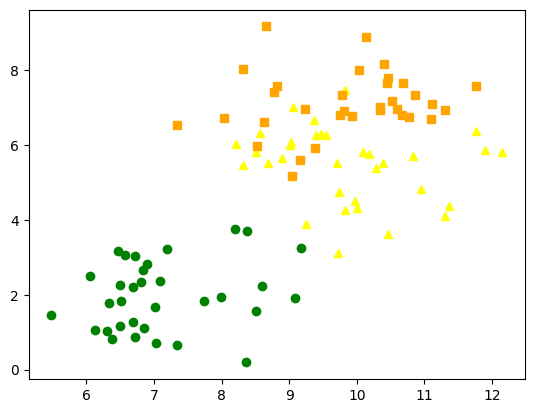

In [9]:
import matplotlib.pyplot as plt
from sklearn import datasets
np.random.seed(4)
X, t = datasets.make_blobs(n_samples=100, centers=3, n_features=2, center_box=(0, 10))
plt.plot(X[:, 0][t == 0], X[:, 1][t == 0], marker='^',linestyle="None" ,color='yellow')
plt.plot(X[:, 0][t == 1], X[:, 1][t == 1], marker='s',linestyle="None",color='orange')
plt.plot(X[:, 0][t == 2], X[:, 1][t == 2], marker='o',linestyle="None",color='green')
plt.show()

For give the colors and how they show on the screen, I'm choosing them to represent a ficticious orange, lemons, and limes.

In [10]:
import pandas as pd
t_fruit = pd.Series(t).map({0:"Lemon",1:"Orange",2:"Lime"})
t_fruit

0     Orange
1      Lemon
2     Orange
3     Orange
4      Lemon
       ...  
95      Lime
96     Lemon
97      Lime
98      Lime
99     Lemon
Length: 100, dtype: object

## Loss functions

We need a simple classifier to examine our loss functions. We'll stick with k-nearest neighbor classifier for this example. We will use the sklearn implementation. 

In [11]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X, t_fruit)

KNeighborsClassifier(n_neighbors=3)

In [12]:
y_fruit_pred = clf.predict(X)
from sklearn.metrics import classification_report
print(classification_report(t_fruit, y_fruit_pred))

              precision    recall  f1-score   support

       Lemon       0.87      0.97      0.92        34
        Lime       1.00      0.97      0.98        33
      Orange       0.97      0.88      0.92        33

    accuracy                           0.94       100
   macro avg       0.95      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100



In [13]:
y_fruit_probs_pred = pd.DataFrame(clf.predict_proba(X),columns=clf.classes_)
y_fruit_probs_pred

,Lemon,Lime,Orange
0,0.333333,0.000000,0.666667
1,1.000000,0.000000,0.000000
2,0.333333,0.000000,0.666667
3,0.000000,0.000000,1.000000
4,0.666667,0.000000,0.333333
...,...,...,...
95,0.000000,1.000000,0.000000
96,0.666667,0.000000,0.333333
97,0.000000,1.000000,0.000000
98,0.000000,1.000000,0.000000


Because we are going to start incorporating pytorch, I am going to start showing you their built-in functions. Below is the KL-divergence. Before we can call that function, we need to define the target. Here ya go:

In [14]:
y_fruit_probs = pd.get_dummies(t_fruit).astype(float)
y_fruit_probs

,Lemon,Lime,Orange
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,1.0,0.0,0.0
...,...,...,...
95,0.0,1.0,0.0
96,1.0,0.0,0.0
97,0.0,1.0,0.0
98,0.0,1.0,0.0


In [15]:
import torch
torch.nn.functional.kl_div

<function torch.nn.functional.kl_div(input: torch.Tensor, target: torch.Tensor, size_average: Optional[bool] = None, reduce: Optional[bool] = None, reduction: str = 'mean', log_target: bool = False) -> torch.Tensor>

In [16]:
import torch
float(torch.nn.functional.kl_div(torch.tensor(np.log(y_fruit_probs_pred.values+1e-10)), torch.tensor(y_fruit_probs.values),reduction='batchmean').numpy())


0.15106440990030112

Now let's implement our own KL-divergence

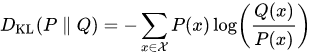

In this notation, $P$ is target.

In [17]:
py487.functional.kl_div(np.log(y_fruit_probs_pred.values+1e-10),y_fruit_probs.values)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

## Cross-entropy

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/39d0c6b14cd7381cd3145718f693c114b84e7960">


Again $P$ is target.

In [ ]:
float(torch.nn.functional.cross_entropy(
    torch.tensor(np.log(y_fruit_probs_pred.values+1e-10)), 
    torch.tensor(y_fruit_probs.values)).numpy())

0.15106441020030112

In [ ]:
py487.functional.cross_entropy(np.log(y_fruit_probs_pred.values+1e-10),y_fruit_probs.values)

0

## Gradient descent

Our first take on gradient descent will assume you can symbolically find the gradient of a function. We will use:

We want to minimize:

$J_1(\theta) = \theta^2$

$J_2(\theta) = (1-\theta)^2$

Gradient descent says:

$\theta = \theta - \alpha \frac{1}{2} \left(\frac{dJ_1}{d\theta}+\frac{dJ_2}{d\theta}\right)$

We will set $\alpha=0.1$.

We will now define the derivatives programmatically:

In [ ]:
gradient_func1 = lambda theta: 2*theta
gradient_func1(2)

4

In [ ]:
gradient_func2 = lambda theta: -2*(1-theta)
gradient_func2(2)

2

In [25]:
thetas = py487.functional.minimize_gradient_descent([gradient_func1,gradient_func2],0.1,5)
pd.Series(thetas)
# please note that I only add the pd.Series, so the output is nicely formatted

0    3.337480e-10
1    1.000000e+00
dtype: float64

In [26]:
J1s = [theta**2 for theta in thetas]
J2s = [(1-theta)**2 for theta in thetas]
results = pd.DataFrame({"theta":thetas, "J1":J1s,"J2":J2s})
results["R"] = (results["J1"]+results["J2"])/2
results

,theta,J1,J2,R
0,3.337480e-10,1.113877e-19,1.000000e+00,0.5
1,1.000000e+00,1.000000e+00,7.128816e-20,0.5


Now what if you can't or don't want to find the derivatives symbolically? 
You can always estimate the gradient analytically using the difference quotient:

$[J(\theta+h)-J(\theta)]/h$,

where h is a scalar parameter. Let's give it a shot:

In [27]:
J1_func = lambda theta: theta**2
J1_func(5)

25

In [28]:
J2_func = lambda theta: (1-theta)**2
J2_func(5)

16

In [29]:
R_func = lambda theta: 1/2*(J1_func(theta)+J2_func(theta))
R_func(5)

20.5

In [30]:
thetas = py487.functional.minimize_gradient_descent_analytically(R_func,0.1,5,0.01)
pd.Series(thetas)

0    0.495
dtype: float64

In [31]:
R_func(thetas[-1])

0.25002499999082317

In [32]:
R_func(0.5)

0.25

In [ ]:
# End of notebook